In [2]:
        !pip install tensorflow opencv-python matplotlib

In [3]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
print("TensorFlow version:", tf.__version__)

In [5]:
!python --version


Python 3.12.2


In [6]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available: 0


In [7]:
pip cache purge


Files removed: 0
Note: you may need to restart the kernel to use updated packages.


In [8]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    print(e)


In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH3 = os.path.join('data', 'negative3')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH3)
os.makedirs(ANC_PATH)

In [ ]:
for directory in os.listdir('lfw-deepfunneled'):
    for file in os.listdir(os.path.join('lfw-deepfunneled', directory)):
        EX_PATH = os.path.join('lfw-deepfunneled', directory, file)
        NEW_PATH = os.path.join(NEG_PATH2, file)
        os.replace(EX_PATH, NEW_PATH)

In [11]:
import uuid

In [12]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\3274c137-176c-11ef-8c84-3ce9f7d2eb40.jpg'

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [ ]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [14]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

NameError: name 'data_aug' is not defined

In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative3 = tf.data.Dataset.list_files(NEG_PATH3+'\*.jpg').take(3000)

<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
C:\Users\DELL\AppData\Local\Temp\ipykernel_21616\3508943538.py:1: SyntaxWarning: invalid escape sequence '\*'
  anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
C:\Users\DELL\AppData\Local\Temp\ipykernel_21616\3508943538.py:2: SyntaxWarning: invalid escape sequence '\*'
  positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
C:\Users\DELL\AppData\Local\Temp\ipykernel_21616\3508943538.py:3: SyntaxWarning: invalid escape sequence '\*'
  negative3 = tf.data.Dataset.list_files(NEG_PATH3+'\*.jpg').take(3000)


In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
print(dir_test.next())

b'data\\anchor\\baa9534c-1270-11ef-942f-3ce9f7d2eb40.jpg'


In [16]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [17]:
img = preprocess('data\\anchor\\a97c8521-131d-11ef-86df-3ce9f7d2eb40.jpg')

In [1]:
img.numpy().max() 

NameError: name 'img' is not defined

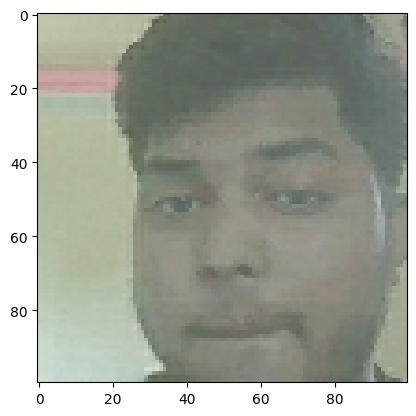

In [19]:
plt.imshow(img)

In [20]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative3, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [21]:
samples = data.as_numpy_iterator()

In [22]:
example = samples.next()

In [23]:
example

(b'data\\anchor\\bd1046a7-131d-11ef-82a5-3ce9f7d2eb40.jpg',
 b'data\\positive\\0c8525fb-053e-11ef-819e-3ce9f7d2eb40.jpg',
 1.0)

In [24]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [25]:
res = preprocess_twin(*example)

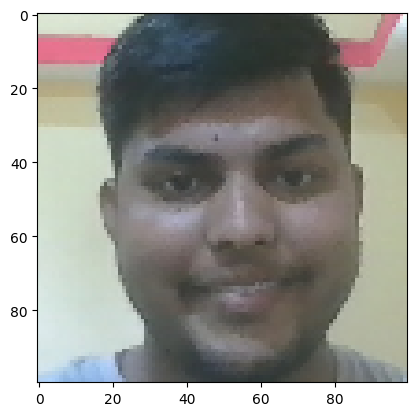

In [26]:

plt.imshow(res[1])

In [27]:
res[2]

1.0

In [28]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [29]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [30]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [31]:
inp = Input(shape=(100,100,3), name='input_image')

In [32]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [33]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [34]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [35]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [36]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [37]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [38]:
mod.summary()


Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [40]:
embedding = make_embedding()

In [41]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        # Convert input lists to TensorFlow tensors
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        
        # Calculate absolute difference between tensors
        return tf.abs(input_embedding - validation_embedding)


In [43]:
l1 = L1Dist()

In [44]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [45]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [46]:
siamese_layer = L1Dist()

In [47]:
distances = siamese_layer(inp_embedding, val_embedding)

In [48]:
classifier = Dense(1, activation='sigmoid')(distances)

In [49]:
classifier

<KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=keras_tensor_21>

In [50]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [51]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (1, None, 4096)           │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (1, None, 1)              │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [53]:
siamese_model = make_siamese_model()

In [54]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_2 (L1Dist)            │ (1, None, 4096)           │               0 │ embedding[2][0],           │
│                               │                           │                 │ embedding[3][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (1, None, 1)              │           4,097 │ l1_dist_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [56]:
opt = tf.keras.optimizers.Adam(1e-4)

In [57]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [58]:
test_batch = train_data.as_numpy_iterator()

In [59]:
batch_1 = test_batch.next()

In [60]:
X = batch_1[:2]

In [61]:
y = batch_1[2]

In [62]:
y


array([1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.],
      dtype=float32)

In [ ]:
tf.losses.BinaryCrossentropy??

In [64]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X=batch[:2]
        y=batch[2]
        yhat=siamese_model(X,training=True)
        y=tf.expand_dims(y,axis=-1)
        y=tf.transpose(y)
        loss=binary_cross_loss(y,yhat)
    print(loss)
    #calculate gradients
    grad=tape.gradient(loss,siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss

In [65]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [66]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [67]:
EPOCHS = 50

In [77]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1199s 5s/step
0.04141279 1.0 1.0

 Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1201s 5s/step
1.5840349e-05 1.0 1.0

 Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1197s 5s/step
1.3411048e-07 1.0 1.0

 Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/stepp
263/263 ━━━━━━━━━━━━━━━━━━━━ 1196s 5s/step
0.020780398 0.98698795 0.99756455

 Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1186s 5s/step
5.140903e-07 1.0 1.0

 Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step4s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1200s 5s/step
4.321341e-07 1.0 1.0

 Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steps/ste
1/1 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step5s/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/st

In [132]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [133]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [134]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step


In [71]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [135]:
# Example list of predictions
#y_hat = [0.3, 0.7, 'invalid', 0.9, None, 0.4, np.array([0.6]), np.array([0.2])]

# Function to safely convert predictions to binary values
def safe_binary_classification(predictions):
    binary_predictions = []
    for prediction in predictions:
        try:
            # Handle cases where prediction might be a numpy array
            if isinstance(prediction, (np.ndarray, list)):
                prediction = prediction.item()
            # Perform the threshold comparison
            binary_value = 1 if float(prediction) > 0.5 else 0
        except (ValueError, TypeError):
            binary_value = 0  # Default value for invalid entries
        binary_predictions.append(binary_value)
    return binary_predictions

# Apply the function to the list of predictions
binary_y_hat = safe_binary_classification(y_hat)

print(binary_y_hat)


[0]


In [73]:
y_true

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [74]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [277]:
import numpy as np
from tensorflow.keras.metrics import Recall

# Example list of predictions and true labels
y_hat = [0.3, 0.7, 'invalid', 0.9, None, 0.4]
y_true = [0, 1, 0, 1, 0, 0]

# Function to convert predictions to binary values safely
def safe_binary_classification(predictions):
    binary_predictions = []
    for prediction in predictions:
        try:
            binary_value = 1 if float(prediction) > 0.5s else 0
        except (ValueError, TypeError):
            binary_value = 0  # Default value for invalid entries
        binary_predictions.append(binary_value)
    return binary_predictions

# Apply the function to the list of predictions
binary_y_hat = safe_binary_classification(y_hat)

# Convert to numpy arrays and ensure correct dtype
binary_y_hat = np.array(binary_y_hat, dtype=np.int32)
y_true = np.array(y_true, dtype=np.int32)

# Initialize the Recall metric
m = Recall()

# Update the state with the true labels and binary predictions
m.update_state(y_true, binary_y_hat)

# Return the Recall result
recall_result = m.result().numpy()
print(recall_result)


1.0


In [75]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.25

In [76]:
import numpy as np
from tensorflow.keras.metrics import Precision

# Example list of predictions and true labels
y_hat = [0.3, 0.7, 'invalid', 0.9, None, 0.4]
y_true = [0, 1, 0, 1, 0, 0]

# Function to convert predictions to binary values safely
def safe_binary_classification(predictions):
    binary_predictions = []
    for prediction in predictions:
        try:
            binary_value = 1 if float(prediction) > 0.6 else 0
        except (ValueError, TypeError):
            binary_value = 0  # Default value for invalid entries
        binary_predictions.append(binary_value)
    return binary_predictions

# Apply the function to the list of predictions
binary_y_hat = safe_binary_classification(y_hat)

# Convert to numpy arrays and ensure correct dtype
binary_y_hat = np.array(binary_y_hat, dtype=np.int32)
y_true = np.array(y_true, dtype=np.int32)

# Initialize the Precision metric
m = Precision()

# Update the state with the true labels and binary predictions
m.update_state(y_true, binary_y_hat)

# Return the Precision result
precision_result = m.result().numpy()
print(precision_result)


1.0


In [77]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

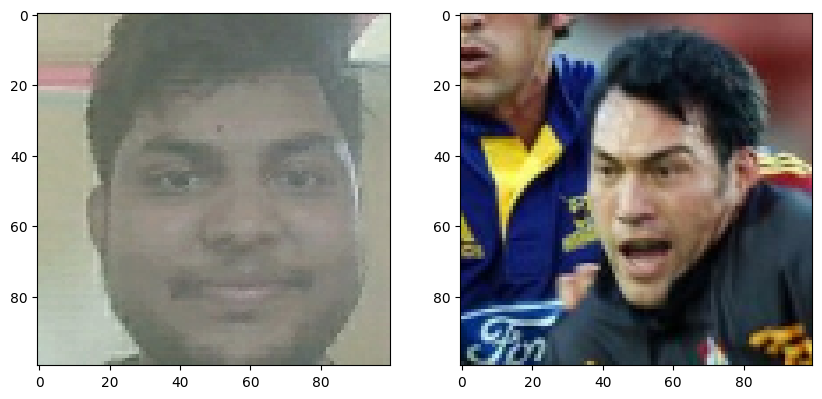

In [78]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

In [282]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [119]:
siamese_model.save('siamesemodelvx4.keras')


In [120]:
L1Dist

__main__.L1Dist

In [121]:
# Reload model 
siamese_model = tf.keras.models.load_model('SiameseModelv5.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [122]:
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [123]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


array([[[0.5169531],
        [0.5169531],
        [0.5169531],
        [0.5169531],
        [0.5169531],
        [0.5169531],
        [0.5169531],
        [0.5169531]]], dtype=float32)

In [124]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_9 (L1Dist)            │ (1, None, 4096)           │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (1, None, 1)              │           4,097 │ l1_dist_9[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [125]:
os.listdir(os.path.join('application_data', 'verification_image'))

['01a179e2-053e-11ef-83c6-3ce9f7d2eb40.jpg',
 '01a82d95-053e-11ef-892a-3ce9f7d2eb40.jpg',
 '01b505c5-053e-11ef-9ea7-3ce9f7d2eb40.jpg',
 '01ba4755-053e-11ef-9163-3ce9f7d2eb40.jpg',
 '01c869ce-053e-11ef-8d56-3ce9f7d2eb40.jpg',
 '01cdb97a-053e-11ef-a7c9-3ce9f7d2eb40.jpg',
 '01f09a20-053e-11ef-9c2a-3ce9f7d2eb40.jpg',
 '01f6b7a1-053e-11ef-a78a-3ce9f7d2eb40.jpg',
 '02df7bcf-053e-11ef-9798-3ce9f7d2eb40.jpg',
 '04c40f55-053e-11ef-abb8-3ce9f7d2eb40.jpg',
 '04d69788-053e-11ef-92b4-3ce9f7d2eb40.jpg',
 '04f5a382-053e-11ef-97b7-3ce9f7d2eb40.jpg',
 '0db26970-053e-11ef-953d-3ce9f7d2eb40.jpg',
 '0e3cb583-053e-11ef-a283-3ce9f7d2eb40.jpg',
 '0e41a44a-053e-11ef-b03f-3ce9f7d2eb40.jpg',
 '0e46f98e-053e-11ef-a71f-3ce9f7d2eb40.jpg',
 '0e5e9056-053e-11ef-80f0-3ce9f7d2eb40.jpg',
 '0f3b1811-053e-11ef-ac01-3ce9f7d2eb40.jpg',
 '0f4c7a36-053e-11ef-895d-3ce9f7d2eb40.jpg',
 '0f6b1f73-053e-11ef-a6e1-3ce9f7d2eb40.jpg',
 '0fe58eab-053e-11ef-8334-3ce9f7d2eb40.jpg',
 '0fefb812-053e-11ef-b0de-3ce9f7d2eb40.jpg',
 '1a4c8f51

In [126]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [127]:
for image in os.listdir(os.path.join('application_data', 'verification_image')):
    validation_img = os.path.join('application_data', 'verification_image', image)
    print(validation_img)

application_data\verification_image\01a179e2-053e-11ef-83c6-3ce9f7d2eb40.jpg
application_data\verification_image\01a82d95-053e-11ef-892a-3ce9f7d2eb40.jpg
application_data\verification_image\01b505c5-053e-11ef-9ea7-3ce9f7d2eb40.jpg
application_data\verification_image\01ba4755-053e-11ef-9163-3ce9f7d2eb40.jpg
application_data\verification_image\01c869ce-053e-11ef-8d56-3ce9f7d2eb40.jpg
application_data\verification_image\01cdb97a-053e-11ef-a7c9-3ce9f7d2eb40.jpg
application_data\verification_image\01f09a20-053e-11ef-9c2a-3ce9f7d2eb40.jpg
application_data\verification_image\01f6b7a1-053e-11ef-a78a-3ce9f7d2eb40.jpg
application_data\verification_image\02df7bcf-053e-11ef-9798-3ce9f7d2eb40.jpg
application_data\verification_image\04c40f55-053e-11ef-abb8-3ce9f7d2eb40.jpg
application_data\verification_image\04d69788-053e-11ef-92b4-3ce9f7d2eb40.jpg
application_data\verification_image\04f5a382-053e-11ef-97b7-3ce9f7d2eb40.jpg
application_data\verification_image\0db26970-053e-11ef-953d-3ce9f7d2eb40.jpg

In [128]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_image')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_image', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_image'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [129]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        # hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        # h, s, v = cv2.split(hsv)

        # lim = 255 - 10
        # v[v > lim] = 255
        # v[v <= lim] -= 10
        
        # final_hsv = cv2.merge((h, s, v))
        # img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.6, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━

In [130]:
np.sum(np.squeeze(results) > 0.6)

0

In [131]:
results

[array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
 array([[[0.5169531]]], dtype=float32),
